In [2]:
!pip install --upgrade git+https://github.com/oKatanaaa/MakiFlow.git

  Cloning https://github.com/oKatanaaa/MakiFlow.git to c:\users\okata\appdata\local\temp\pip-req-build-o_k3lpzg


In [3]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [4]:
import tensorflow as tf

In [5]:
from gct.tools import load_cifar10
import matplotlib.pyplot as plt
from makiflow.models.classificator import Classificator, CETrainer
from makiflow.generators.classification import cycle_generator
import tensorflow as tf
from makiflow.layers import *
import numpy as np
%matplotlib inline

In [6]:
(Xtrain, Ytrain), (Xtest, Ytest), (X_mean, X_std) = load_cifar10()

170500096/170498071 [==============================] - 35s 0us/step


In [7]:
BATCH_SIZE = 64

In [8]:
def block(x, id, in_f, out_f):
    SX = x
    FX = x
    
    FX = BatchNormLayer(D=in_f, name=f'bn_main_{id}_1')(FX)
    FX = ActivationLayer(name=f'act_1_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=in_f, out_f=out_f, name=f'conv_main_{id}_1', activation=None)(FX)
    
    FX = BatchNormLayer(D=out_f, name=f'bn_main_{id}_2')(FX)
    FX = ActivationLayer(name=f'act_2_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=out_f, out_f=out_f, name=f'conv_main_{id}_2', activation=None)(FX)

    if in_f != out_f:
        SX = BatchNormLayer(D=in_f, name=f'bn_skip_{id}_1')(SX)
        SX = ConvLayer(kw=1, kh=1, in_f=in_f, out_f=out_f, name=f'conv_skip_{id}', activation=None)(SX)
    
    x_sum = SumLayer(name=f'sum_{id}')([FX, SX])
    return x_sum

In [9]:
# Create a model

In [10]:
inp = InputLayer(input_shape=[BATCH_SIZE, 32, 32, 3], name='input')
x = block(inp, id=1, in_f=3, out_f=32)
x = MaxPoolLayer(name='mp1')(x)
# 16x16
x = block(x, id=2, in_f=32, out_f=64)
x = block(x, id=3, in_f=64, out_f=64)
x = MaxPoolLayer(name='mp2')(x)
# 8x8
x = block(x, id=4, in_f=64, out_f=128)
x = block(x, id=5, in_f=128, out_f=128)
x = MaxPoolLayer(name='mp3')(x)
# 4x4
x = block(x, id=6, in_f=128, out_f=256)
x = block(x, id=7, in_f=256, out_f=256)
x = MaxPoolLayer(name='mp4')(x)
# 2x2
x = FlattenLayer('flat')(x)
# 4*256 = 1024
x = DenseLayer(in_d=1024, out_d=256, name='projection_head')(x)
x = DenseLayer(in_d=256, out_d=10, activation=None, name='classification_head')(x)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [11]:
model = Classificator(in_x=inp, out_x=x)
sess = tf.Session()
model.set_session(sess)

In [12]:
# Setup training

In [13]:
trainer = CETrainer(model=model, train_inputs=[InputLayer(input_shape=[BATCH_SIZE, 32, 32, 3], name='input')])

In [14]:
trainer.compile()



Loss is built.


In [15]:
opt = tf.train.AdamOptimizer()

In [16]:
gen = cycle_generator(Xtrain, Ytrain.reshape(-1), BATCH_SIZE)

In [17]:
info1 = trainer.fit_generator(gen, optimizer=opt, epochs=5, iter=100, print_period=10)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

New optimizer is used.


 17%|█████████████▊                                                                   | 17/100 [00:04<00:09,  8.67it/s]

Epoch: 0
Cross_Entropy: 5.66011 
Training_Loss: 5.66011 




 25%|████████████████████▎                                                            | 25/100 [00:04<00:04, 15.69it/s]

Epoch: 0
Cross_Entropy: 3.64757 
Training_Loss: 3.64757 




 38%|██████████████████████████████▊                                                  | 38/100 [00:04<00:02, 27.43it/s]

Epoch: 0
Cross_Entropy: 2.61756 
Training_Loss: 2.61756 




 46%|█████████████████████████████████████▎                                           | 46/100 [00:05<00:01, 32.49it/s]

Epoch: 0
Cross_Entropy: 2.21724 
Training_Loss: 2.21724 




 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:05<00:01, 36.70it/s]

Epoch: 0
Cross_Entropy: 1.99727 
Training_Loss: 1.99727 




 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:00, 38.04it/s]

Epoch: 0
Cross_Entropy: 1.84818 
Training_Loss: 1.84818 




 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:05<00:00, 38.74it/s]

Epoch: 0
Cross_Entropy: 1.76300 
Training_Loss: 1.76300 




 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:00, 39.27it/s]

Epoch: 0
Cross_Entropy: 1.77637 
Training_Loss: 1.77637 




 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:06<00:00, 39.62it/s]

Epoch: 0
Cross_Entropy: 1.71003 
Training_Loss: 1.71003 




  5%|████                                                                              | 5/100 [00:00<00:02, 39.99it/s]

Epoch: 0
Cross_Entropy: 1.61553 
Training_Loss: 1.61553 




 17%|█████████████▊                                                                   | 17/100 [00:00<00:02, 39.66it/s]

Epoch: 1
Cross_Entropy: 1.58169 
Training_Loss: 1.58169 




 25%|████████████████████▎                                                            | 25/100 [00:00<00:01, 39.75it/s]

Epoch: 1
Cross_Entropy: 1.59654 
Training_Loss: 1.59654 




 37%|█████████████████████████████▉                                                   | 37/100 [00:00<00:01, 39.67it/s]

Epoch: 1
Cross_Entropy: 1.60524 
Training_Loss: 1.60524 




 45%|████████████████████████████████████▍                                            | 45/100 [00:01<00:01, 39.23it/s]

Epoch: 1
Cross_Entropy: 1.60016 
Training_Loss: 1.60016 




 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:01<00:01, 39.73it/s]

Epoch: 1
Cross_Entropy: 1.56306 
Training_Loss: 1.56306 




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:01<00:00, 40.06it/s]

Epoch: 1
Cross_Entropy: 1.57626 
Training_Loss: 1.57626 




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:01<00:00, 39.92it/s]

Epoch: 1
Cross_Entropy: 1.52193 
Training_Loss: 1.52193 




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:02<00:00, 39.66it/s]

Epoch: 1
Cross_Entropy: 1.51423 
Training_Loss: 1.51423 




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:02<00:00, 39.79it/s]

Epoch: 1
Cross_Entropy: 1.47706 
Training_Loss: 1.47706 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 39.60it/s]

Epoch: 1
Cross_Entropy: 1.51247 
Training_Loss: 1.51247 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.78it/s]

Epoch: 2
Cross_Entropy: 1.51583 
Training_Loss: 1.51583 




 25%|████████████████████▎                                                            | 25/100 [00:00<00:01, 39.88it/s]

Epoch: 2
Cross_Entropy: 1.46649 
Training_Loss: 1.46649 




 37%|█████████████████████████████▉                                                   | 37/100 [00:00<00:01, 39.81it/s]

Epoch: 2
Cross_Entropy: 1.45179 
Training_Loss: 1.45179 




 45%|████████████████████████████████████▍                                            | 45/100 [00:01<00:01, 39.80it/s]

Epoch: 2
Cross_Entropy: 1.43511 
Training_Loss: 1.43511 




 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:01<00:01, 39.83it/s]

Epoch: 2
Cross_Entropy: 1.49078 
Training_Loss: 1.49078 




 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:01<00:00, 39.93it/s]

Epoch: 2
Cross_Entropy: 1.43904 
Training_Loss: 1.43904 




 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:01<00:00, 39.82it/s]

Epoch: 2
Cross_Entropy: 1.38598 
Training_Loss: 1.38598 




 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:02<00:00, 39.85it/s]

Epoch: 2
Cross_Entropy: 1.36715 
Training_Loss: 1.36715 




 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:02<00:00, 39.67it/s]

Epoch: 2
Cross_Entropy: 1.35773 
Training_Loss: 1.35773 




  5%|████                                                                              | 5/100 [00:00<00:02, 40.31it/s]

Epoch: 2
Cross_Entropy: 1.35888 
Training_Loss: 1.35888 




 15%|████████████▏                                                                    | 15/100 [00:00<00:02, 40.06it/s]

Epoch: 3
Cross_Entropy: 1.35421 
Training_Loss: 1.35421 




 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 39.93it/s]

Epoch: 3
Cross_Entropy: 1.38089 
Training_Loss: 1.38089 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 39.91it/s]

Epoch: 3
Cross_Entropy: 1.33112 
Training_Loss: 1.33112 




 44%|███████████████████████████████████▋                                             | 44/100 [00:01<00:01, 39.67it/s]

Epoch: 3
Cross_Entropy: 1.33040 
Training_Loss: 1.33040 




 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:01<00:01, 39.92it/s]

Epoch: 3
Cross_Entropy: 1.28791 
Training_Loss: 1.28791 




 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:01<00:00, 39.87it/s]

Epoch: 3
Cross_Entropy: 1.26411 
Training_Loss: 1.26411 




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:01<00:00, 39.77it/s]

Epoch: 3
Cross_Entropy: 1.22405 
Training_Loss: 1.22405 




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:02<00:00, 39.60it/s]

Epoch: 3
Cross_Entropy: 1.23281 
Training_Loss: 1.23281 




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:02<00:00, 39.77it/s]

Epoch: 3
Cross_Entropy: 1.26189 
Training_Loss: 1.26189 




  8%|██████▌                                                                           | 8/100 [00:00<00:02, 39.99it/s]

Epoch: 3
Cross_Entropy: 1.22501 
Training_Loss: 1.22501 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.61it/s]

Epoch: 4
Cross_Entropy: 1.21485 
Training_Loss: 1.21485 




 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 39.60it/s]

Epoch: 4
Cross_Entropy: 1.20442 
Training_Loss: 1.20442 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 39.60it/s]

Epoch: 4
Cross_Entropy: 1.25398 
Training_Loss: 1.25398 




 45%|████████████████████████████████████▍                                            | 45/100 [00:01<00:01, 39.73it/s]

Epoch: 4
Cross_Entropy: 1.24379 
Training_Loss: 1.24379 




 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:01<00:01, 39.68it/s]

Epoch: 4
Cross_Entropy: 1.23061 
Training_Loss: 1.23061 




 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:01<00:00, 39.62it/s]

Epoch: 4
Cross_Entropy: 1.18852 
Training_Loss: 1.18852 




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:01<00:00, 39.72it/s]

Epoch: 4
Cross_Entropy: 1.19900 
Training_Loss: 1.19900 




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:02<00:00, 39.65it/s]

Epoch: 4
Cross_Entropy: 1.19802 
Training_Loss: 1.19802 




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:02<00:00, 39.68it/s]

Epoch: 4
Cross_Entropy: 1.14865 
Training_Loss: 1.14865 




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.66it/s]

Epoch: 4
Cross_Entropy: 1.15436 
Training_Loss: 1.15436 




In [18]:
model.evaluate(Xtest, Ytest.reshape(-1))

157it [00:01, 118.51it/s]


0.4054

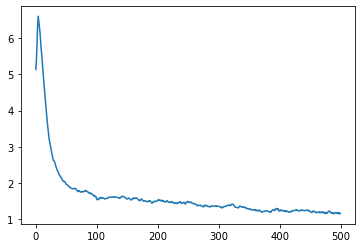

In [19]:
plt.plot(info1[CETrainer.TRAINING_LOSS])